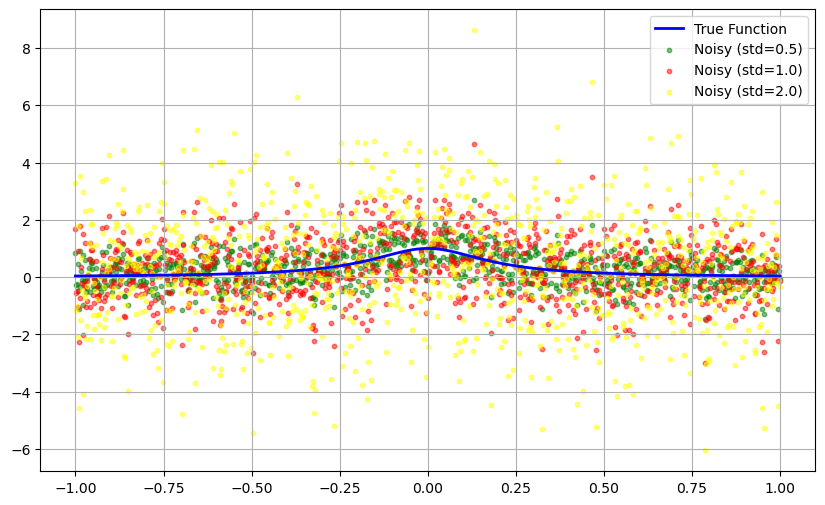

In [41]:
from data import generate_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

n = 1000

x, y, y_noisy1 = generate_dataset(n=n, noise_std=0.5, random_state=1)
_, _, y_noisy2 = generate_dataset(n=n, noise_std=1.0, random_state=1)
_, _, y_noisy3 = generate_dataset(n=n, noise_std=2.0, random_state=1)
_, _, y = generate_dataset(n=n, noise_std=0, random_state=1)


plt.figure(figsize=(10, 6))
plt.plot(x, y, color="blue", linewidth=2, label="True Function")
plt.scatter(x, y_noisy1, s=10, color="green", alpha=0.5, label="Noisy (std=0.5)")
plt.scatter(x, y_noisy2, s=10, color="red", alpha=0.5, label="Noisy (std=1.0)")
plt.scatter(x, y_noisy3, s=10, color="yellow", alpha=0.5, label="Noisy (std=2.0)")
plt.legend()
plt.grid()
plt.show()


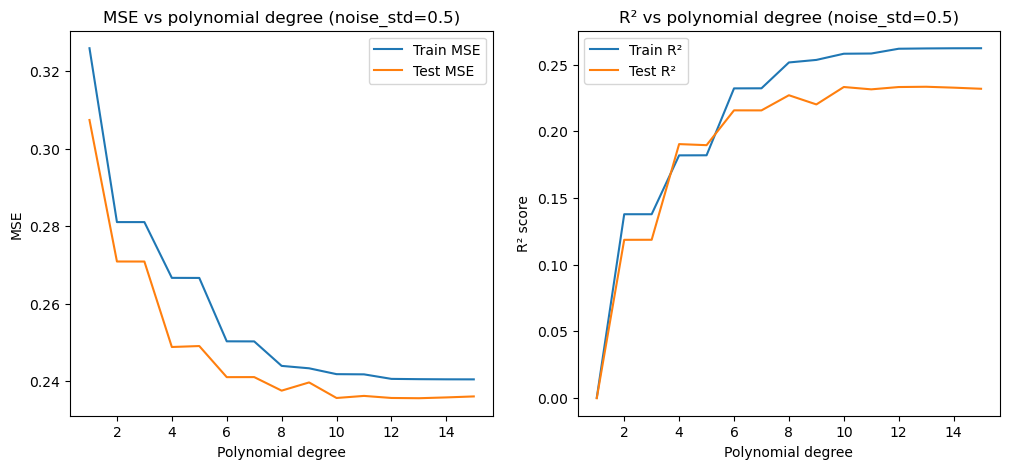

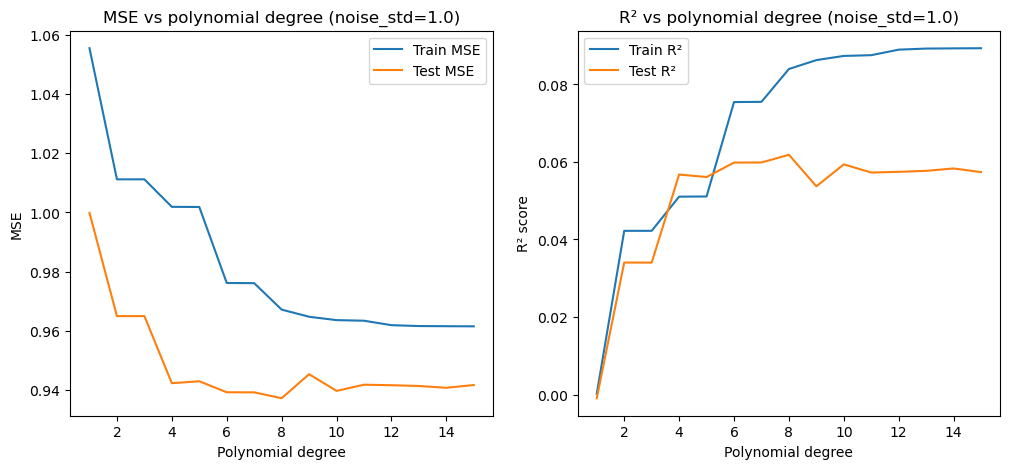

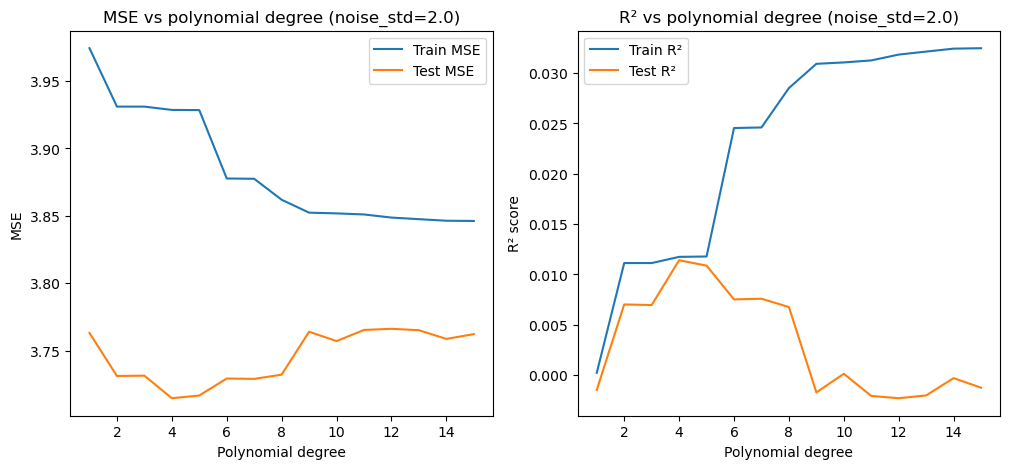

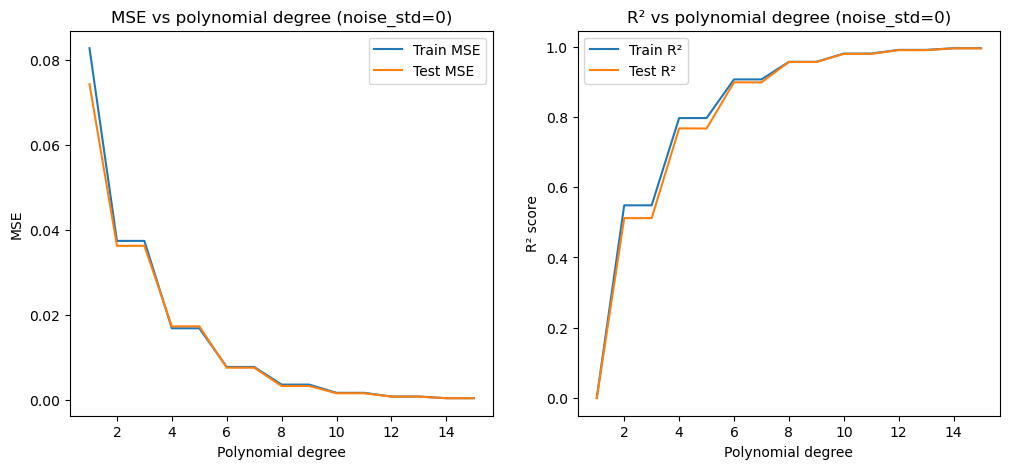

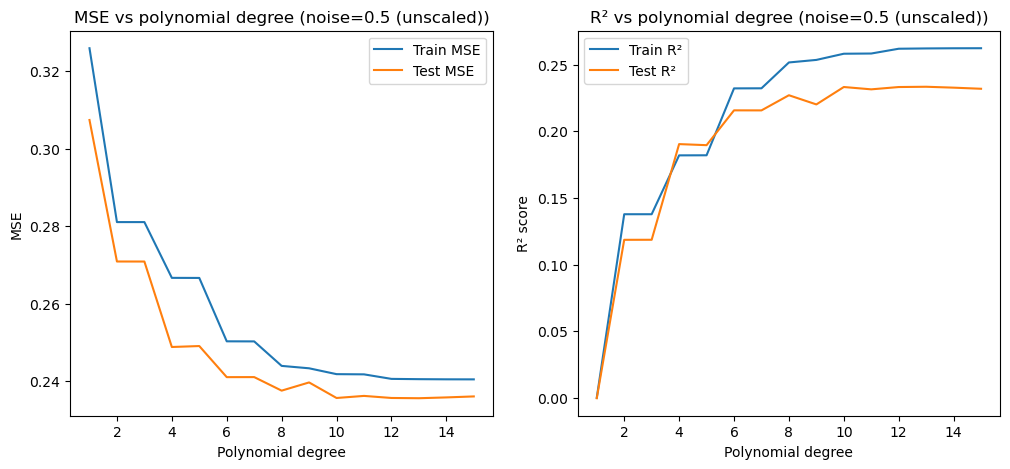

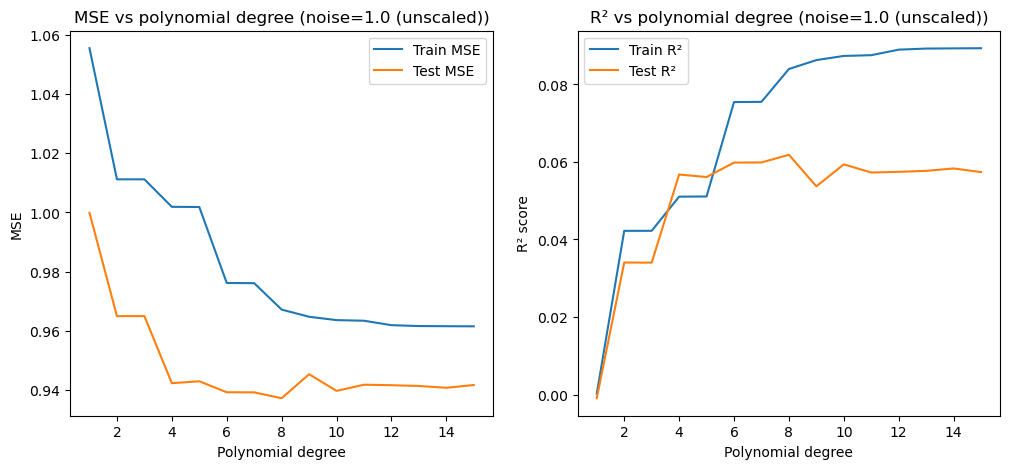

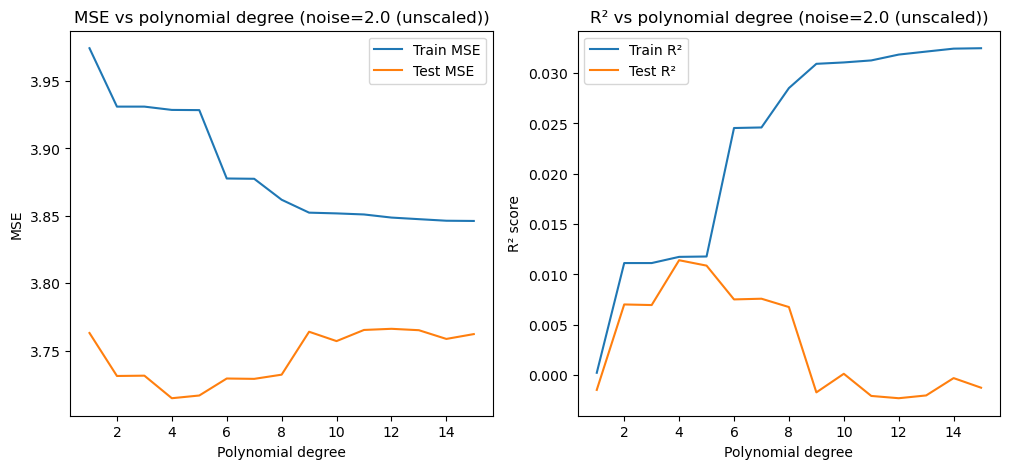

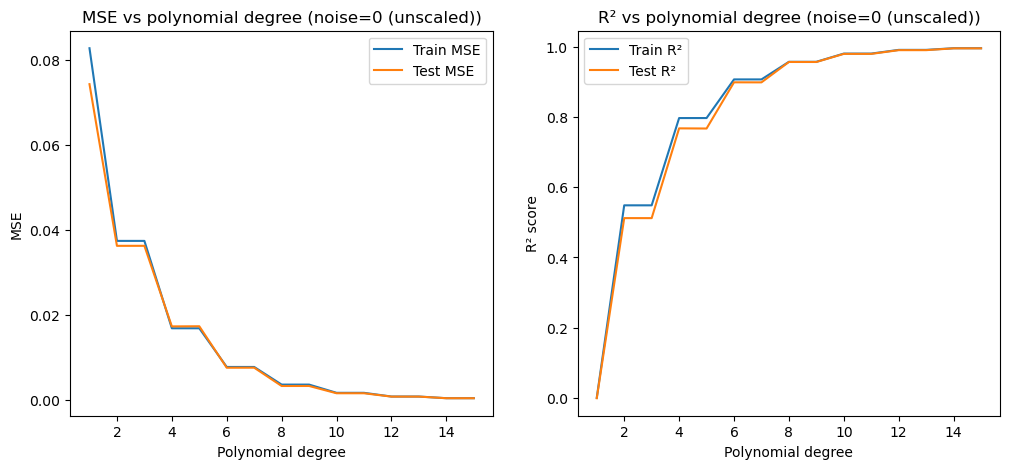

In [42]:
def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def ols_fit(X, y):
    return np.linalg.pinv(X) @ y


def ols_predict(x, beta):
    X = design_matrix(x, len(beta)-1)
    return X @ beta


def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)



x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)


_, _, y1_train, y1_test = train_test_split(x, y_noisy1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(x, y_noisy2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(x, y_noisy3, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

degrees = range(1, 16)

def evaluate_OLS(y_train, y_test, label):
    mse_train, mse_test = [], []
    r2_train, r2_test = [], []
    
    for d in degrees:
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)

        beta = ols_fit(X_train, y_train)

        y_train_hat = X_train @ beta
        y_test_hat = X_test @ beta

        mse_train.append(mse(y_train, y_train_hat))
        mse_test.append(mse(y_test, y_test_hat))

        r2_train.append(r2(y_train, y_train_hat))
        r2_test.append(r2(y_test, y_test_hat))
    

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(degrees, mse_train, label="Train MSE")
    plt.plot(degrees, mse_test, label="Test MSE")
    plt.xlabel("Polynomial degree")
    plt.ylabel("MSE")
    plt.legend()
    plt.title(f"MSE vs polynomial degree ({label})")

    plt.subplot(1, 2, 2)
    plt.plot(degrees, r2_train, label="Train R²")
    plt.plot(degrees, r2_test, label="Test R²")
    plt.xlabel("Polynomial degree")
    plt.ylabel("R² score")
    plt.legend()
    plt.title(f"R² vs polynomial degree ({label})")

    plt.show()

# Evaluer for begge støy-nivåene
evaluate_OLS(y1_train, y1_test, label="noise_std=0.5")
evaluate_OLS(y2_train, y2_test, label="noise_std=1.0")
evaluate_OLS(y3_train, y3_test, label="noise_std=2.0")
evaluate_OLS(y_train, y_test, label="noise_std=0")
evaluate_OLS(y1_train, y1_test, label="noise=0.5 (unscaled)")
evaluate_OLS(y2_train, y2_test, label="noise=1.0 (unscaled)")
evaluate_OLS(y3_train, y3_test, label="noise=2.0 (unscaled)")
evaluate_OLS(y_train, y_test, label="noise=0 (unscaled)")

In [43]:
def evaluate_OLS_best(y_train, y_test, x_train_scaled, x_test_scaled, degrees, label):
    results = []

    for d in degrees:
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)

        beta = ols_fit(X_train, y_train)
        y_train_hat = X_train @ beta
        y_test_hat = X_test @ beta

        results.append({
            "degree": d,
            "mse_train": mse(y_train, y_train_hat),
            "mse_test": mse(y_test, y_test_hat),
            "r2_train": r2(y_train, y_train_hat),
            "r2_test": r2(y_test, y_test_hat)
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df["mse_test"].idxmin()]

    print(f"Beste OLS-resultat for {label}:")
    print(f"  → Grad = {best_row.degree}")
    print(f"  → Test MSE = {best_row.mse_test:.4f}")
    print(f"  → Train MSE = {best_row.mse_train:.4f}")
    print(f"  → Test R² = {best_row.r2_test:.4f}")
    print(f"  → Train R² = {best_row.r2_train:.4f}")

    return best_row


In [44]:
best1 = evaluate_OLS_best(y1_train, y1_test, x_train_scaled, x_test_scaled, degrees, "noise=0.5")
best2 = evaluate_OLS_best(y2_train, y2_test, x_train_scaled, x_test_scaled, degrees, "noise=1.0")
best3 = evaluate_OLS_best(y3_train, y3_test, x_train_scaled, x_test_scaled, degrees, "noise=2.0")
best0 = evaluate_OLS_best(y_train, y_test, x_train_scaled, x_test_scaled, degrees, "noise=0")
best1_u = evaluate_OLS_best(y1_train, y1_test, x_train, x_test, degrees, "noise=0.5 (unscaled)")
best2_u = evaluate_OLS_best(y2_train, y2_test, x_train, x_test, degrees, "noise=1.0 (unscaled)")
best3_u = evaluate_OLS_best(y3_train, y3_test, x_train, x_test, degrees, "noise=2.0 (unscaled)")
best0_u = evaluate_OLS_best(y_train, y_test, x_train, x_test, degrees, "noise=0 (unscaled)")

best_results_ols = pd.DataFrame([best0, best1, best2, best3, best0_u, best1_u, best2_u, best3_u])
best_results_ols.index = ["noise=0", "noise=0.5", "noise=1.0", "noise=2.0", "noise=0 (unscaled)", "noise=0.5 (unscaled)", "noise=1.0 (unscaled)", "noise=2.0 (unscaled)"]

display(best_results_ols)


Beste OLS-resultat for noise=0.5:
  → Grad = 13.0
  → Test MSE = 0.2356
  → Train MSE = 0.2405
  → Test R² = 0.2335
  → Train R² = 0.2622
Beste OLS-resultat for noise=1.0:
  → Grad = 8.0
  → Test MSE = 0.9372
  → Train MSE = 0.9671
  → Test R² = 0.0618
  → Train R² = 0.0840
Beste OLS-resultat for noise=2.0:
  → Grad = 4.0
  → Test MSE = 3.7147
  → Train MSE = 3.9286
  → Test R² = 0.0114
  → Train R² = 0.0117
Beste OLS-resultat for noise=0:
  → Grad = 14.0
  → Test MSE = 0.0003
  → Train MSE = 0.0003
  → Test R² = 0.9958
  → Train R² = 0.9961
Beste OLS-resultat for noise=0.5 (unscaled):
  → Grad = 13.0
  → Test MSE = 0.2356
  → Train MSE = 0.2405
  → Test R² = 0.2335
  → Train R² = 0.2622
Beste OLS-resultat for noise=1.0 (unscaled):
  → Grad = 8.0
  → Test MSE = 0.9372
  → Train MSE = 0.9671
  → Test R² = 0.0618
  → Train R² = 0.0840
Beste OLS-resultat for noise=2.0 (unscaled):
  → Grad = 4.0
  → Test MSE = 3.7147
  → Train MSE = 3.9286
  → Test R² = 0.0114
  → Train R² = 0.0117
Beste O

,degree,mse_train,mse_test,r2_train,r2_test
noise=0,14.0,0.000322,0.000315,0.996112,0.995758
noise=0.5,13.0,0.240507,0.235588,0.262213,0.233468
noise=1.0,8.0,0.967137,0.937153,0.083972,0.061848
noise=2.0,4.0,3.928572,3.714675,0.011749,0.011415
noise=0 (unscaled),14.0,0.000322,0.000315,0.996112,0.995758
noise=0.5 (unscaled),13.0,0.240507,0.235588,0.262213,0.233468
noise=1.0 (unscaled),8.0,0.967137,0.937153,0.083972,0.061848
noise=2.0 (unscaled),4.0,3.928572,3.714675,0.011749,0.011415
